In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [22]:
deficiency_types = ['Bacterial leaf blight','Brown spot','Leaf smut']
data_dir = '/content/sample_data/Rice Diseases'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [58]:
train_data = []
for defects_id, sp in enumerate(deficiency_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'deficiencyID','deficiencytypes'])
train.head()

,File,deficiencyID,deficiencytypes
0,Bacterial leaf blight/DSC_0382.JPG,0,Bacterial leaf blight
1,Bacterial leaf blight/DSC_0405.JPG,0,Bacterial leaf blight
2,Bacterial leaf blight/DSC_0397.JPG,0,Bacterial leaf blight
3,Bacterial leaf blight/DSC_0377.JPG,0,Bacterial leaf blight
4,Bacterial leaf blight/DSC_0388.JPG,0,Bacterial leaf blight


In [24]:
# Randomize the order of training set
SEED = 30
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,deficiencyID,deficiencytypes
0,Bacterial leaf blight/DSC_0405.JPG,0,Bacterial leaf blight
1,Bacterial leaf blight/DSC_0382.JPG,0,Bacterial leaf blight
2,Brown spot/DSC_0305.JPG,1,Brown spot
3,Brown spot/DSC_0333.JPG,1,Brown spot
4,Bacterial leaf blight/DSC_0373.JPG,0,Bacterial leaf blight


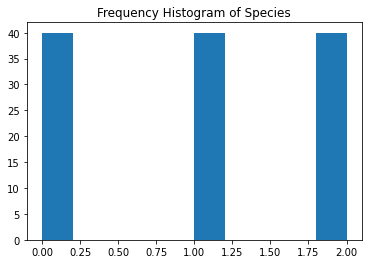

<Figure size 864x864 with 0 Axes>

In [25]:
#Plot a histogram
plt.hist(train['deficiencyID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

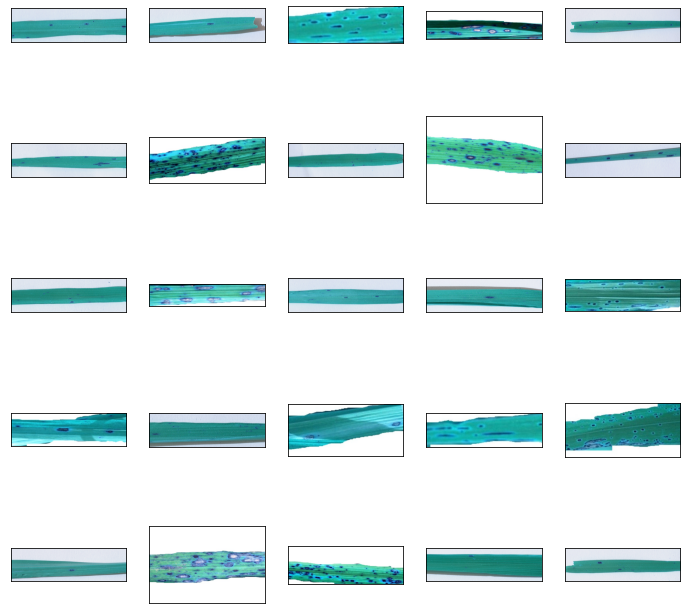

In [38]:
# Display images for different species
def plot_defects(deficiency_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12,12))
    defect_files = train['File'][train['deficiencytypes'] == deficiency_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Brown spot', 5, 5)

In [27]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [28]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

120it [00:05, 23.15it/s]

Train Shape: (120, 64, 64, 3)


In [29]:
Y_train = train['deficiencyID'].values
Y_train = to_categorical(Y_train, num_classes=3)

In [51]:
BATCH_SIZE = 20

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=SEED)

In [52]:
EPOCHS = 25
SIZE=64
N_ch=3

In [32]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(3,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model


In [53]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2624

In [54]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 0s 19ms/step
Final Loss: 1.372422218322754, Final Accuracy: 0.375


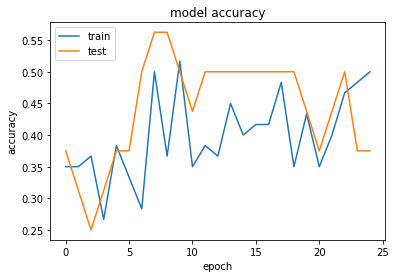

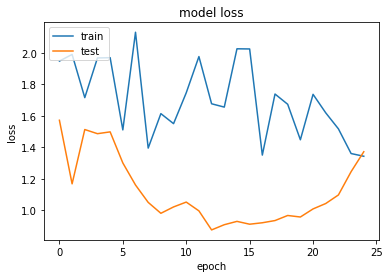

In [56]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Testing Disease Prediction**

[0.23272265 0.12447987 0.6427974 ]


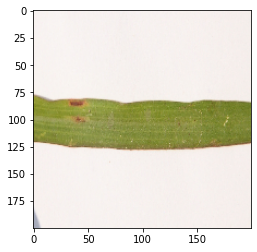

Prediction: Leaf smut


In [57]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/sample_data/Rice Diseases/Leaf smut/DSC_0314.JPG', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/sample_data/Rice Diseases/Leaf smut/DSC_0314.JPG', grayscale=False, target_size=(200, 200))
disease_class = ['Bacterial leaf blight','Brown spot','Leaf smut']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])